### MonthlySVD
This code shows as simple way to:
- Read in a .nc file using xarray
- Generate montly anomalies from climatology of monthly means
- detrend data by grid cell
- calculate singular value decomposition by grid cell, dim = month * year


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils

# Try scipy to detrend
import segment as sg
import scipy
from scipy import signal

# some resources for plotting
import matplotlib.pyplot as plt
#import cartopy
#import cartopy.crs as ccrs
%matplotlib inline

In [2]:
## User defined options
model = 'CLM5_GSWP3'
var  = 'GPP'
suff = 'lnd/proc/tseries/month_1/'
path = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'+suff
file = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var +'.185001-201412.nc'
file

'/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.GPP.185001-201412.nc'

#### Read in your data

In [3]:
# wrapping the time_set_mid utility corrects time being read in by xr.open_dataset
# data sets have lots of coords, variables, and attributes
ds   = utils.time_set_mid(xr.open_dataset(file, decode_times=True), 'time')
area = ds.area
landfrac = ds.landfrac
da = ds[var]    # strips out the extra coords and variables from the dataset
dataset = da.to_dataset()  # convert the previously created unnamed DataArray to Dataset with a variable named "array"
print(dataset)

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1980)
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * time     (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00
Data variables:
    GPP      (time, lat, lon) float32 ...


### Quick look at annual cycle for a grid cell

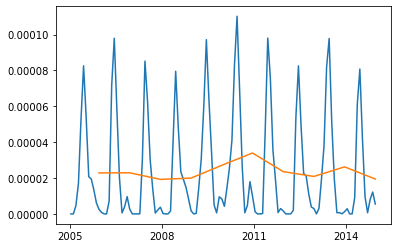

In [4]:
years = 10
months = years * 12
tlat = 40   #-5
tlon = 40   #300
ds_test = ds.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
ds_last = ds_test.isel(time=slice(-months,None))
da = ds_last[var]    # strips out the extra coords and variables from the dataset
dataset = da.to_dataset()  # convert the previously created unnamed DataArray to Dataset with a variable named "array"
ds_ann  = dataset.apply(utils.weighted_annual_mean)
plt.plot(ds_last.time['time'], ds_last.get(var), '-' );
plt.plot(ds_ann.time['time'], ds_ann.get(var), '-' );

### Calculate climatology and anomalies

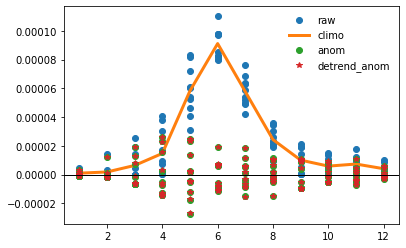

In [5]:
# esmlab anomaly function needs time_bounds in the dataset!
# test to see of climatology and anomaly functions see to work appropriately?
ds_climo = esmlab.core.climatology(ds_last,freq='mon')
ds_anom = esmlab.core.anomaly(ds_last, clim_freq='mon', time_coord_name='time')
ds_detrend = signal.detrend(ds_anom.get(var))
plt.plot(ds_last.time['time.month'], ds_last.get(var), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend, '*' );
plt.legend(labels=('raw','climo','anom','detrend_anom'),frameon = False)
plt.axhline(0, color='black', lw=1);

### Do we need to detrend data?

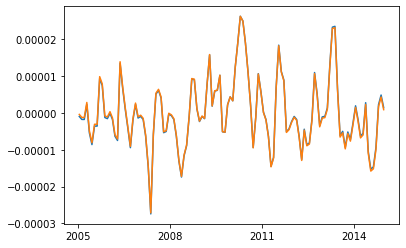

In [6]:
plt.plot(ds_anom.time['time'], ds_anom.get(var), '-' )
plt.plot(ds_anom.time['time'], ds_detrend, '-' );

### Start singular vector decomposition
#### This is from Gretchen's CLM_SVD code 

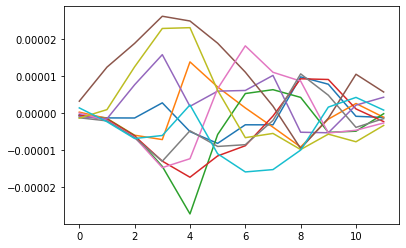

In [7]:
# Reshape month x year
# uniqueyears=np.unique(ds_detrend.time['time.year'])
# iavmatrix=np.zeros([12, len(uniqueyears)])
iavmatrix=np.zeros([12, years])
for iyr in range(years):
    iavmatrix[0:12, iyr]=ds_detrend[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
#print(iavmatrix.shape)
#print(iavmatrix)
#print(ds_anom.get(var)[0:12])

plt.figure();
plt.plot(iavmatrix);

In [8]:
import SVD_tools as svd
monthlimits=np.array([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
DOYlimits=np.cumsum(monthlimits)


In [9]:
U, s, V = np.linalg.svd(iavmatrix, full_matrices=False)
Nyears=iavmatrix.shape[1]
Nmonths=iavmatrix.shape[0]
S = np.diag(s)

# IF Nmonth < Nyears
# Sigma needs to have same dimensions as iavMatrix (12,nyear)
'''We can achieve this by creating a new Sigma matrix of all zero values that is 
   m x n (e.g. more rows) and populate the first n x n part of the matrix with 
   the square diagonal matrix calculated via diag().
   https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
   '''
# create m x n Sigma matrix
Sigma = np.zeros((Nmonths, Nyears))
# populate Sigma with n x n diagonal matrix
# Sigma[:Nmonths, :Nmonths] = np.diag(s)

print('U = ',U.shape)  #(nmonth,nmonth)
print('S = ',S.shape)  #(nmonth,nmonth)
print('s = ',s.shape)  #(nmonth,)
print('V = ',V.shape)  #(nmonth,nyear)
print('Sigma = ',Sigma.shape)
#print(Nyears, Nmonths)
sv_vectors_sif = np.zeros((Nyears,Nmonths),dtype='float')
sv_weights_sif = np.zeros((Nyears,Nyears),dtype='float')
##Here we define the vector shapes by taking the dot product of U and S. 
##0 and 1 refer to the first and second singular vector, respectively
for iyear in range(Nyears):
    sv_vectors_sif[iyear,:]=np.dot(U,S)[:,iyear]
    sv_weights_sif[iyear,:]=V[iyear,:]  
print('sv_vector = ',sv_vectors_sif.shape)
print('sv_weights = ',sv_weights_sif.shape)
            

U =  (12, 10)
S =  (10, 10)
s =  (10,)
V =  (10, 10)
Sigma =  (12, 10)
sv_vector =  (10, 12)
sv_weights =  (10, 10)


In [10]:
#assign the 2-D matrix (year x month) to decompose
## TODO, the decompose functions doesn't like to work with too many years of data?  
[vectors, weights]=svd.decompose(iavmatrix) #Call the function to calculate the singular vectors and their annual weights

[theta,varfrac]=svd.calc_redistribution(vectors, weights, iavmatrix)
varfrac.shape

12 10
[0.69973357 0.56796765 0.28032477 0.82604226 0.00754681 0.06234543
 0.13219817 0.19312888 0.04216031 0.19681049]


(10,)

[ 1.16911422e-06  6.04743897e-06  1.59598263e-05  2.75135900e-05
  2.88215646e-05  1.50630834e-05  3.64890927e-06 -1.22307408e-06
 -1.32204076e-05 -4.14932076e-06  4.17255213e-06  2.85314988e-06]
(10, 12)
(10, 10)


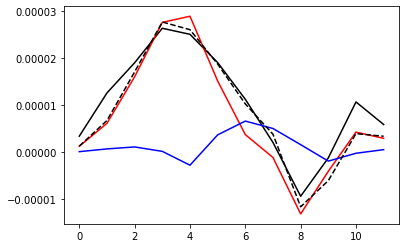

In [11]:
# sanity check make sure that the  first two singular vectors generally reproduce the IAV for a given year
year2check=5
Obs=iavmatrix[:,year2check]
SV1contrib=vectors[0,:]*weights[0,year2check]
SV2contrib=vectors[1,:]*weights[1,year2check]
SV3contrib=vectors[2,:]*weights[2,year2check]
print(SV1contrib)
plt.plot(Obs, 'k-')
plt.plot(SV1contrib, 'r-')
plt.plot(SV2contrib, 'b-')
#plt.plot(SV3contrib, 'g-')
plt.plot(SV1contrib+SV2contrib, 'k--')
print(vectors.shape)
print(weights.shape)
#print(weights)
#plt.figure(3)
#plt.plot(sif_years_anomaly[:,5],'k-',label="Obs")
#plt.plot(sv_vectors_sif[0,:]*sv_weights_sif[0,5],'r-',label="SV1")
#plt.plot(sv_vectors_sif[1,:]*sv_weights_sif[1,5],'b-',label="SV2")
#plt.plot(sv_vectors_sif[0,:]*sv_weights_sif[0,5]+sv_vectors_sif[1,:]*sv_weights_sif[1,5],'k--',label="SV1+2")

2.9826040831455952e-05


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


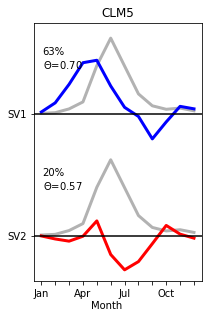

In [12]:
##Plot First and Second Singular Vectors
fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
print(ymax)
vectors2plot=vectors*5000  #This is a totally arbitrary scale factor, decided by me, to make figures look good!
#mm2plot=mm
mm2plot=ds_climo.get(var)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.5,str(int(varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%theta[0]))
ax1.text(0.5,.1,str(int(varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%theta[1]))
ax1.title.set_text('CLM5')
ax1.text(4,-0.29,'Month')
plt.tight_layout()
plt.savefig('SVD_CLM5_ex.eps')


In [13]:
print(weights.shape)

(10, 10)


### Calculate global anomalies

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(120, 192, 288)


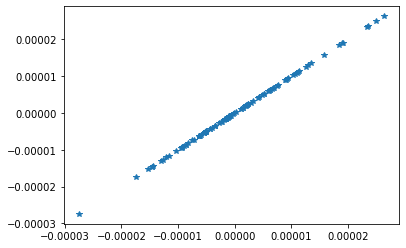

In [14]:
ds2 = ds.isel(time=slice(-months,None))
ds_climo2 = esmlab.core.climatology(ds2,freq='mon')
ds_anom2  = esmlab.core.anomaly(ds2, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time
ds_anom2    
ds_temp = ds_anom2.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
plt.plot(ds_temp.get(var), ds_anom.get(var), '*' )
anom_np = ds_anom2.get(var).values # returns a 3d array with dims (time,lat,lon)
print(anom_np.shape)

In [15]:
## define function that wraps in detrending, reshaping, and SVD & returns a np.array
def svd_wrap(anom, years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (year x month) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac


12 10
[0.69973357 0.56796765 0.28032476 0.82604227 0.00754721 0.06234542
 0.13219818 0.1931289  0.04216037 0.19681416]
----
[6.39635094e-01 2.04124522e-01 7.24708032e-02 3.73721419e-02
 3.25509777e-02 7.57544537e-03 4.20886667e-03 1.87523107e-03
 1.85493114e-04 2.63535885e-06]
!!!
[6.39635095e-01 2.04124521e-01 7.24708028e-02 3.73721437e-02
 3.25509773e-02 7.57544576e-03 4.20886625e-03 1.87523082e-03
 1.85493129e-04 2.63538553e-06]


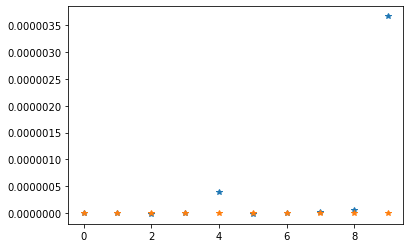

In [16]:
# Make sure wrapper results are the same as above
[theta_wrap, varfrac_wrap] = svd_wrap(ds_temp.get(var).values, years)
plt.plot(theta_wrap - theta, '*') ;
plt.plot(varfrac_wrap - varfrac, '*') ;

print('----')
print(varfrac_wrap)
print('!!!')
print(varfrac)

In [17]:
print(np.isnan(anom_np[:,50,0])[0])
[theta_wrap, varfrac_wrap] = svd_wrap(anom_np[:,50,0], years)
print(theta_wrap)
print(varfrac_wrap)
print([years,years])

True
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[10, 10]


In [18]:
# Now try this on the full dataset
svd_global = xr.apply_ufunc(svd_wrap, anom_np, years, vectorize=True)

IndexError: invalid index to scalar variable.

In [ ]:
# this approach is too slow and sensitive to initial estimate of break point
Y  = ds_anom.get(var)
initialBreakpoints = [[1950],[1960],[1970]]
for i in initialBreakpoints:
    print(i)
    reg = sg.SegmentedLinearReg( decY, Y, i )
    print(reg)
    